# Linear Learner Demo - Regression

This notebook demonstrates how to use AWS SageMaker's Linear Learner algorithm for **regression** - predicting a continuous numeric value (like price, temperature, or sales).

---

## Business Context

### What business problem does this solve?

Regression helps businesses predict numerical outcomes based on data. Instead of rough estimates, you can use historical data to make data-driven predictions.

### Real-world SMB Example: Predicting House Sale Prices

Imagine you run a small real estate agency. You want to predict the actual sale price of a house, not just whether it's "high" or "low." This helps you:

- **Price listings accurately**: Set competitive prices that attract buyers while maximizing seller returns
- **Identify undervalued properties**: Find investment opportunities where market price is below predicted value
- **Advise clients confidently**: Provide data-backed price recommendations

In this demo, we'll predict the actual sale price of houses in dollars.

---

**Prerequisites**: You must have already run the `LinearLearner_Data_Validator.ipynb` notebook, which produces a cleaned CSV file ready for SageMaker.

---
## Step 1: Setup and Configuration

First, we need to import the Python libraries (pre-written code packages) that we'll use throughout this notebook.

**What each library does:**
- `pandas` (pd): Works with data tables (like Excel spreadsheets) - a **DataFrame** is a table of data with rows and columns
- `numpy` (np): Performs mathematical calculations on numbers and arrays
- `sklearn`: Provides tools for splitting data and measuring model performance
- `boto3`: Connects Python to Amazon Web Services (AWS) - AWS is Amazon's cloud computing platform
- `sagemaker`: Amazon's machine learning service that trains and hosts models

**What to expect:** After running this cell, you'll see a confirmation that all libraries loaded successfully.

In [1]:
# ============================================================
# CONFIGURATION - THE ONLY CELL YOU NEED TO EDIT!
# ============================================================
# 
# FOR YOUR OWN PROJECT, CHANGE THESE 3 THINGS:
#   1. CLEANED_DATA_FILE - your cleaned CSV from Data Validator
#   2. PROJECT_NAME - a short name for your project  
#   3. ENDPOINT_NAME - a unique name for your model endpoint
#
# That's it! Everything else runs automatically.
# ============================================================

# 1. Your cleaned CSV file (output from Data Validator notebook)
#    For the demo, we use the pre-configured regression dataset
CLEANED_DATA_FILE = "AmesHousing_REGRESSION.csv"

# 2. Project name (used for organizing files in S3 cloud storage)
#    Use only letters, numbers, and hyphens - NO SPACES
PROJECT_NAME = "regression-housing-demo"

# 3. Endpoint name (the "address" for your prediction service)
#    Use only letters, numbers, and hyphens - NO SPACES
ENDPOINT_NAME = "regression-learner-endpoint"

# ============================================================
# DON'T CHANGE ANYTHING BELOW THIS LINE
# (unless you know what you're doing!)
# ============================================================

print("Configuration loaded!")
print(f"  Data file:     {CLEANED_DATA_FILE}")
print(f"  Project name:  {PROJECT_NAME}")
print(f"  Endpoint name: {ENDPOINT_NAME}")

Configuration loaded!
  Data file:     AmesHousing_REGRESSION.csv
  Project name:  regression-housing-demo
  Endpoint name: regression-learner-endpoint


In [2]:
# Import data handling libraries
import pandas as pd      # For working with data tables (DataFrames)
import numpy as np       # For numerical operations

# Import visualization library
import matplotlib.pyplot as plt  # For creating charts and graphs

# Import machine learning utilities from scikit-learn
from sklearn.model_selection import train_test_split  # Splits data into training and testing sets
from sklearn.metrics import (                         # Tools to measure how well the model performs
    mean_squared_error,   # Average of squared differences between predicted and actual
    mean_absolute_error,  # Average of absolute differences between predicted and actual
    r2_score              # How much variance in the data is explained by the model (0 to 1)
)

# Import AWS libraries
import boto3             # AWS SDK - lets Python talk to AWS services
import sagemaker         # Amazon's machine learning platform
from sagemaker import Session, get_execution_role  # Session management and permissions
from sagemaker.estimator import Estimator          # Used to configure and train models
from sagemaker.inputs import TrainingInput         # Tells SageMaker where training data is located
from sagemaker.serializers import CSVSerializer    # Formats data as CSV for the model
from sagemaker.deserializers import JSONDeserializer  # Reads JSON responses from the model

print("All libraries imported successfully!")
print(f"SageMaker SDK version: {sagemaker.__version__}")

Unable to load JumpStart region config.
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.12/site-packages/sagemaker/jumpstart/constants.py", line 69, in _load_region_config
    with open(filepath) as f:
         ^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/home/ec2-user/anaconda3/envs/python3/lib/python3.12/site-packages/sagemaker/jumpstart/region_config.json'


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
All libraries imported successfully!
SageMaker SDK version: 2.256.1


---
## Step 2: Load Prepared Data

We'll load the cleaned CSV file that was produced by the Data Validator notebook.

**Important**: The Data Validator already:
- Removed columns with too many missing values
- Filled in remaining missing values
- Converted text categories to numbers
- Moved the target column to the first position
- Removed headers (SageMaker Linear Learner requires no headers)

**What is a DataFrame?**
A DataFrame is like a spreadsheet or Excel table in Python. It has rows (individual records) and columns (different attributes or features).

**What to expect:** You'll see the number of rows and columns in your data, plus statistics about your target variable (what you're predicting).

In [3]:
# Load the cleaned data file
# header=None tells pandas there are no column names in the file
df = pd.read_csv(CLEANED_DATA_FILE, header=None)

# The first column (index 0) is the target variable (what we want to predict)
# All other columns are features (the information we use to make predictions)
print("="*60)
print("DATA LOADED SUCCESSFULLY")
print("="*60)
print(f"Number of rows (samples): {len(df):,}")
print(f"Number of columns: {len(df.columns)} (1 target + {len(df.columns)-1} features)")
print()

# Verify the data looks correct
print("First 5 rows of the dataset:")
print("(Column 0 is the target variable, columns 1+ are features)")
print(df.head())

DATA LOADED SUCCESSFULLY
Number of rows (samples): 2,930
Number of columns: 198 (1 target + 197 features)

First 5 rows of the dataset:
(Column 0 is the target variable, columns 1+ are features)
        0     1      2        3         4    5    6       7       8    \
0  215000.0  20.0  141.0  31770.0  0.151195  6.0  5.0  1960.0  1960.0   
1  105000.0  20.0   80.0  11622.0  0.151195  5.0  6.0  1961.0  1961.0   
2  172000.0  20.0   81.0  14267.0  0.151195  6.0  6.0  1958.0  1958.0   
3  244000.0  20.0   93.0  11160.0  0.151195  7.0  5.0  1968.0  1968.0   
4  189900.0  60.0   74.0  13830.0  0.056314  5.0  5.0  1997.0  1998.0   

        9    ...  188  189  190  191  192  193  194  195  196  197  
0  0.030034  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  
1  0.350171  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  
2  0.143345  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  
3  0.030034  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  
4  0.350171  ...  0.0

In [4]:
# Check the distribution of the target variable (what we're predicting)
# For regression, the target is a continuous number
target_column = df.iloc[:, 0]  # Get the first column (target)

print("="*60)
print("TARGET VARIABLE STATISTICS")
print("="*60)
print()
print(f"Minimum value:  ${target_column.min():,.2f}")
print(f"Maximum value:  ${target_column.max():,.2f}")
print(f"Average (mean): ${target_column.mean():,.2f}")
print(f"Median:         ${target_column.median():,.2f}")
print(f"Std Deviation:  ${target_column.std():,.2f}")
print()

# Check for potential issues
if target_column.min() < 0:
    print("Note: Target contains negative values.")

# Calculate skewness (how lopsided the distribution is)
skewness = target_column.skew()
if abs(skewness) > 1:
    print(f"Note: Target is skewed (skewness = {skewness:.2f}).")
    print("This is common for price data and may affect predictions.")

TARGET VARIABLE STATISTICS

Minimum value:  $12,789.00
Maximum value:  $755,000.00
Average (mean): $180,796.06
Median:         $160,000.00
Std Deviation:  $79,886.69

Note: Target is skewed (skewness = 1.74).
This is common for price data and may affect predictions.


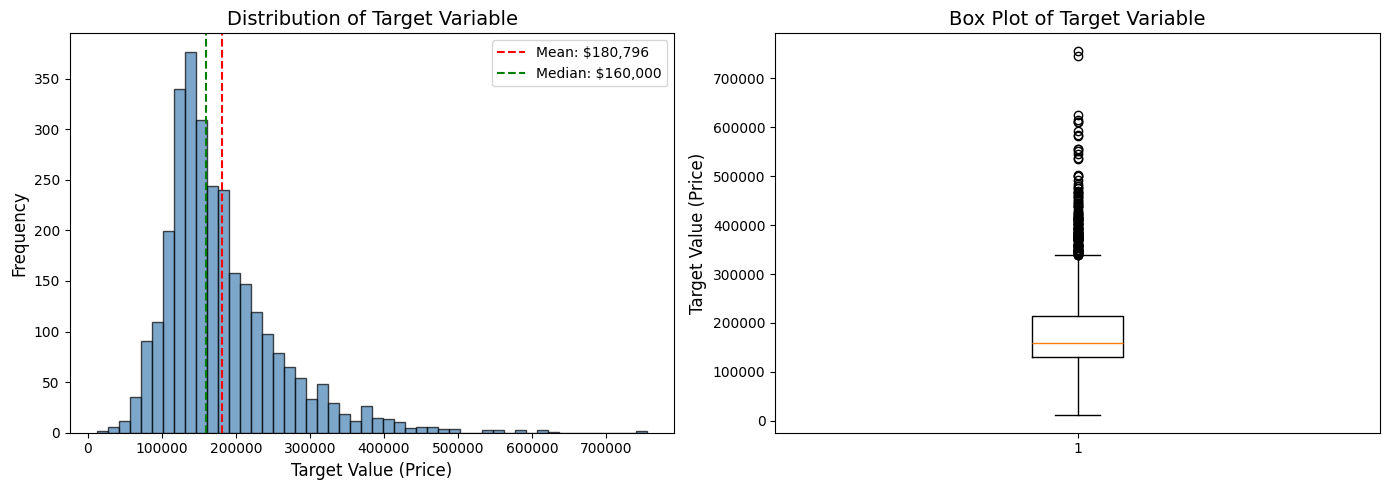

The histogram shows how prices are distributed.
The box plot shows the median (line), quartiles (box), and outliers (dots).


In [5]:
# Visualize the target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram (shows distribution of values)
axes[0].hist(target_column, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(target_column.mean(), color='red', linestyle='--', label=f'Mean: ${target_column.mean():,.0f}')
axes[0].axvline(target_column.median(), color='green', linestyle='--', label=f'Median: ${target_column.median():,.0f}')
axes[0].set_xlabel('Target Value (Price)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Target Variable', fontsize=14)
axes[0].legend()

# Box plot (shows outliers and spread)
axes[1].boxplot(target_column, vert=True)
axes[1].set_ylabel('Target Value (Price)', fontsize=12)
axes[1].set_title('Box Plot of Target Variable', fontsize=14)

plt.tight_layout()
plt.show()

print("The histogram shows how prices are distributed.")
print("The box plot shows the median (line), quartiles (box), and outliers (dots).")

---
## Step 3: Prepare Data for SageMaker

Before training, we need to:
1. **Split the data** into training (80%) and validation (20%) sets
2. **Save to CSV files** in the format SageMaker expects (target column first, no headers)

**Why split the data?**
- **Training set**: Used to teach the model patterns in the data
- **Validation set**: Used to test how well the model performs on data it hasn't seen

This helps us detect "overfitting" - when a model memorizes the training data but can't generalize to new data.

**What to expect:** You'll see the sizes of your training and validation sets.

In [6]:
# Separate features (X) and target (y)
# The target is column 0, features are all other columns
y = df.iloc[:, 0]      # Target variable (what we want to predict)
X = df.iloc[:, 1:]     # Features (information used for prediction)

# Split into training (80%) and validation (20%) sets
# random_state=42 ensures we get the same split every time we run this code
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2,      # 20% for validation
    random_state=42     # For reproducibility
)

print("="*60)
print("DATA SPLIT COMPLETE")
print("="*60)
print(f"Training set:   {len(X_train):,} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation set: {len(X_val):,} samples ({len(X_val)/len(df)*100:.1f}%)")
print(f"Features per sample: {X_train.shape[1]}")

DATA SPLIT COMPLETE
Training set:   2,344 samples (80.0%)
Validation set: 586 samples (20.0%)
Features per sample: 197


In [7]:
# Combine target and features back together (target must be first column)
# SageMaker Linear Learner expects: target, feature1, feature2, ...
train_data = pd.concat([y_train.reset_index(drop=True), 
                        X_train.reset_index(drop=True)], axis=1)
val_data = pd.concat([y_val.reset_index(drop=True), 
                      X_val.reset_index(drop=True)], axis=1)

# Save to CSV files without headers or index
# SageMaker Linear Learner requires this specific format
train_file = "train_regression.csv"
val_file = "validation_regression.csv"

train_data.to_csv(train_file, index=False, header=False)
val_data.to_csv(val_file, index=False, header=False)

print(f"Training data saved to: {train_file}")
print(f"Validation data saved to: {val_file}")

Training data saved to: train_regression.csv
Validation data saved to: validation_regression.csv


---
## Step 4: Set Up SageMaker Session

Now we connect to AWS SageMaker. This involves:
1. Creating a **session** (connection to AWS)
2. Getting our **IAM role** (permissions to use AWS resources)
3. Identifying our **S3 bucket** (cloud storage for data)

**What is S3?**
Amazon S3 (Simple Storage Service) is like a hard drive in the cloud. SageMaker reads training data from S3 and saves trained models to S3.

**What is an IAM Role?**
IAM (Identity and Access Management) roles control what AWS services can do. Our role gives SageMaker permission to read our data and create resources. In AWS Learner Lab, this is pre-configured as "LabRole".

**What to expect:** You'll see the AWS region, S3 bucket name, and IAM role being used.

In [8]:
# Create a SageMaker session
# This establishes our connection to AWS SageMaker
sagemaker_session = Session()

# Get the IAM role that gives SageMaker permission to access resources
# In AWS Learner Lab, this is pre-configured as "LabRole"
role = get_execution_role()

# Get the default S3 bucket for this SageMaker session
# S3 buckets store our training data and model outputs
bucket = sagemaker_session.default_bucket()

# Get the AWS region we're working in
region = sagemaker_session.boto_region_name

# Create a prefix (folder path) for organizing our files in S3
prefix = f"sagemaker/{PROJECT_NAME}"

print("="*60)
print("SAGEMAKER SESSION CONFIGURED")
print("="*60)
print(f"AWS Region: {region}")
print(f"S3 Bucket: {bucket}")
print(f"S3 Prefix: {prefix}")
print(f"IAM Role: {role.split('/')[-1]}")  # Just show the role name

SAGEMAKER SESSION CONFIGURED
AWS Region: us-east-1
S3 Bucket: sagemaker-us-east-1-938371320235
S3 Prefix: sagemaker/regression-housing-demo
IAM Role: LabRole


---
## Step 5: Upload Data to S3

SageMaker training jobs read data from S3 (cloud storage), not from local files. We need to upload our training and validation CSV files to S3.

**Why S3?**
- SageMaker runs on cloud servers that don't have access to your local computer
- S3 provides fast, reliable storage that SageMaker can access
- Multiple training jobs can read the same data simultaneously

**What to expect:** You'll see the S3 paths (like web addresses) where your data was uploaded.

In [9]:
# Upload training data to S3
train_s3_uri = sagemaker_session.upload_data(
    path=train_file,       # Local file to upload
    bucket=bucket,         # S3 bucket name
    key_prefix=prefix      # Folder path within the bucket
)

# Upload validation data to S3
val_s3_uri = sagemaker_session.upload_data(
    path=val_file,
    bucket=bucket,
    key_prefix=prefix
)

print("="*60)
print("DATA UPLOADED TO S3")
print("="*60)
print(f"Training data:   {train_s3_uri}")
print(f"Validation data: {val_s3_uri}")

DATA UPLOADED TO S3
Training data:   s3://sagemaker-us-east-1-938371320235/sagemaker/regression-housing-demo/train_regression.csv
Validation data: s3://sagemaker-us-east-1-938371320235/sagemaker/regression-housing-demo/validation_regression.csv


---
## Step 6: Configure the Linear Learner Estimator

Now we configure the Linear Learner algorithm. An **Estimator** is SageMaker's way of defining:
- Which algorithm to use
- What type of computer (instance) to run it on
- Where to save the results

**Key Parameters Explained:**
- `predictor_type='regressor'`: Tells Linear Learner we're predicting a continuous number (not a category)
- `feature_dim`: The number of input features (columns) in our data
- `mini_batch_size`: How many samples to process at once during training (a **training job** is the process where the computer learns patterns from your data)

**What to expect:** You'll see a summary of how the model is configured.

In [10]:
# Get the container image for Linear Learner
# This is a pre-built Docker image that contains the Linear Learner algorithm
container = sagemaker.image_uris.retrieve(
    framework="linear-learner",
    region=region
)

# Calculate the number of features (exclude the target column)
num_features = X_train.shape[1]

# Create the Estimator
# This configures HOW the model will be trained
linear_learner = Estimator(
    image_uri=container,                         # The algorithm container
    role=role,                                   # IAM role for permissions
    instance_count=1,                            # Number of training machines
    instance_type='ml.m5.large',                 # Machine type (Learner Lab compatible)
    output_path=f's3://{bucket}/{prefix}/output', # Where to save the trained model
    sagemaker_session=sagemaker_session
)

# Set the hyperparameters (settings that control how the algorithm learns)
linear_learner.set_hyperparameters(
    feature_dim=num_features,           # Number of input features
    predictor_type='regressor',         # We're doing regression (predicting numbers)
    mini_batch_size=100                 # Process 100 samples at a time
)

print("="*60)
print("LINEAR LEARNER CONFIGURED")
print("="*60)
print(f"Algorithm: Linear Learner")
print(f"Problem Type: Regression")
print(f"Number of Features: {num_features}")
print(f"Training Instance: ml.m5.large")
print(f"Mini-batch Size: 100")

LINEAR LEARNER CONFIGURED
Algorithm: Linear Learner
Problem Type: Regression
Number of Features: 197
Training Instance: ml.m5.large
Mini-batch Size: 100


---
## Step 7: Train the Model

Now we start the training job! This is where the computer learns patterns from your data.

**What happens during training?**
1. SageMaker spins up a cloud computer (the instance type we specified)
2. It downloads the training data from S3
3. The Linear Learner algorithm processes the data in mini-batches
4. It adjusts its internal weights to minimize prediction errors
5. The trained model is saved to S3

**This typically takes 3-5 minutes.** You'll see progress updates below.

**What to expect:** Training logs will appear showing the progress. When done, you'll see "TRAINING COMPLETE!"

In [11]:
# Create TrainingInput objects that tell SageMaker where to find the data
train_input = TrainingInput(
    s3_data=train_s3_uri,
    content_type="text/csv"  # Our data is in CSV format
)

val_input = TrainingInput(
    s3_data=val_s3_uri,
    content_type="text/csv"
)

print("Starting training job...")
print("This typically takes 3-5 minutes. Please wait.")
print()

# Start the training job
# The fit() method blocks until training is complete
linear_learner.fit(
    inputs={
        'train': train_input,
        'validation': val_input
    }
)

print()
print("="*60)
print("TRAINING COMPLETE!")
print("="*60)

INFO:sagemaker:Creating training-job with name: linear-learner-2026-01-28-12-45-42-683


Starting training job...
This typically takes 3-5 minutes. Please wait.

2026-01-28 12:45:44 Starting - Starting the training job...
2026-01-28 12:45:59 Starting - Preparing the instances for training...
2026-01-28 12:46:24 Downloading - Downloading input data...
2026-01-28 12:47:15 Downloading - Downloading the training image.........
2026-01-28 12:48:31 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/28/2026 12:48:35 INFO 139833882937152] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07

---
## Step 8: Deploy the Model

The trained model is just a file in S3. To use it for predictions, we need to **deploy** it to an **endpoint**.

**What is an Endpoint?**
An endpoint is like a web address (URL) where you can send data and get predictions back. It's a cloud server running your trained model 24/7, ready to make predictions.

**Important Cost Note:**
Endpoints cost money as long as they're running! Always delete endpoints when you're done (Step 11).

**This typically takes 3-5 minutes.**

**What to expect:** You'll see a message when the endpoint is ready to receive predictions.

In [12]:
# ============================================================
# HELPER FUNCTION: Safe endpoint cleanup
# ============================================================
# This function handles all the tricky edge cases when students run
# the notebook multiple times (endpoint creating, deleting, etc.)

import time

def wait_for_endpoint_deletion(sm_client, endpoint_name, max_wait_minutes=15):
    """
    Safely wait for an endpoint to be fully deleted.
    Handles all endpoint states: Creating, InService, Updating, Deleting, Failed
    Also cleans up the endpoint configuration to prevent conflicts on re-deployment.
    """
    print(f"Checking endpoint status for '{endpoint_name}'...")
    
    start_time = time.time()
    max_wait_seconds = max_wait_minutes * 60
    
    while True:
        # Check if we have exceeded max wait time
        elapsed = time.time() - start_time
        if elapsed > max_wait_seconds:
            print(f"WARNING: Timed out after {max_wait_minutes} minutes.")
            print("The endpoint may still be processing. Please check the SageMaker console.")
            return False
        
        try:
            response = sm_client.describe_endpoint(EndpointName=endpoint_name)
            status = response['EndpointStatus']
            
            if status == 'InService':
                print(f"  Endpoint is InService. Requesting deletion...")
                sm_client.delete_endpoint(EndpointName=endpoint_name)
                print(f"  Deletion requested. Waiting for completion...")
            
            elif status == 'Creating':
                # Cannot delete while creating - must wait for it to finish first
                mins_elapsed = int(elapsed // 60)
                secs_elapsed = int(elapsed % 60)
                print(f"  Endpoint is being created ({mins_elapsed}m {secs_elapsed}s elapsed)...")
                print(f"  Cannot delete until creation completes. Please wait...")
            
            elif status == 'Updating':
                # Cannot delete while updating - must wait
                print(f"  Endpoint is being updated. Waiting for it to finish...")
            
            elif status == 'Deleting':
                mins_elapsed = int(elapsed // 60)
                secs_elapsed = int(elapsed % 60)
                print(f"  Endpoint is being deleted ({mins_elapsed}m {secs_elapsed}s elapsed)...")
            
            elif status == 'Failed':
                print(f"  Endpoint is in Failed state. Requesting deletion...")
                try:
                    sm_client.delete_endpoint(EndpointName=endpoint_name)
                except:
                    pass  # May already be cleaning up
            
            else:
                print(f"  Endpoint status: {status}. Waiting...")
            
            # Wait before checking again
            time.sleep(15)
        
        except sm_client.exceptions.ClientError as e:
            if 'Could not find endpoint' in str(e):
                print(f"  Endpoint '{endpoint_name}' has been fully deleted (or never existed).")
                # NOW ALSO DELETE THE ENDPOINT CONFIGURATION
                try:
                    sm_client.delete_endpoint_config(EndpointConfigName=endpoint_name)
                    print(f"  Endpoint configuration '{endpoint_name}' deleted.")
                except sm_client.exceptions.ClientError as config_error:
                    if 'Could not find endpoint configuration' in str(config_error):
                        print(f"  Endpoint configuration already deleted (or never existed).")
                    else:
                        print(f"  Note: Could not delete endpoint config: {config_error}")
                return True
            else:
                print(f"  Unexpected error: {e}")
                return False

# Create the SageMaker client
sm_client = boto3.client('sagemaker')

# FIRST: Clean up any existing endpoint configuration (even if endpoint does not exist)
try:
    sm_client.delete_endpoint_config(EndpointConfigName=ENDPOINT_NAME)
    print(f"Deleted existing endpoint configuration '{ENDPOINT_NAME}'.")
except sm_client.exceptions.ClientError as e:
    if 'Could not find endpoint configuration' in str(e):
        pass  # No config exists, which is fine
    else:
        print(f"Note: {e}")

# Check if endpoint exists and clean it up if necessary
try:
    response = sm_client.describe_endpoint(EndpointName=ENDPOINT_NAME)
    status = response['EndpointStatus']
    print(f"Found existing endpoint '{ENDPOINT_NAME}' with status: {status}")
    print("Cleaning up before deployment...")
    print()
    success = wait_for_endpoint_deletion(sm_client, ENDPOINT_NAME)
    if success:
        print()
        print("Cleanup complete! Ready for deployment.")
    else:
        print()
        print("WARNING: Cleanup may not be complete. Proceeding anyway...")
except sm_client.exceptions.ClientError:
    print(f"No existing endpoint named '{ENDPOINT_NAME}' found. Ready for deployment.")

print()
print("Deploying model to endpoint...")
print("This typically takes 3-5 minutes. Please wait.")
print()

Deleted existing endpoint configuration 'regression-learner-endpoint'.
No existing endpoint named 'regression-learner-endpoint' found. Ready for deployment.

Deploying model to endpoint...
This typically takes 3-5 minutes. Please wait.



In [13]:
# Deploy the trained model to create a prediction endpoint
predictor = linear_learner.deploy(
    initial_instance_count=1,       # Number of servers to run the model
    instance_type='ml.m5.large',    # Server type (Learner Lab compatible)
    endpoint_name=ENDPOINT_NAME     # Name for the endpoint
)

# Configure how to send data to and receive data from the endpoint
predictor.serializer = CSVSerializer()      # Send data as CSV
predictor.deserializer = JSONDeserializer() # Receive responses as JSON

print("="*60)
print("MODEL DEPLOYED SUCCESSFULLY!")
print("="*60)
print(f"Endpoint Name: {ENDPOINT_NAME}")
print(f"Endpoint is now ready to receive predictions.")

INFO:sagemaker:Creating model with name: linear-learner-2026-01-28-12-49-30-507
INFO:sagemaker:Creating endpoint-config with name regression-learner-endpoint
INFO:sagemaker:Creating endpoint with name regression-learner-endpoint


-------!============================================================
MODEL DEPLOYED SUCCESSFULLY!
Endpoint Name: regression-learner-endpoint
Endpoint is now ready to receive predictions.


---
## Step 9: Test the Deployed Model

Let's test the model by sending some sample data and getting predictions.

**What the model returns:**
- `score`: The predicted value (in our case, the predicted house price in dollars)

**What to expect:** You'll see predictions for 5 sample houses, showing the predicted price, actual price, and the error (difference).

In [14]:
# Test with a few samples from the validation set
# We'll use the first 5 samples
test_samples = X_val.head(5).values
actual_values = y_val.head(5).values

# Send the samples to the endpoint for prediction
response = predictor.predict(test_samples)

print("="*60)
print("SAMPLE PREDICTIONS")
print("="*60)
print()

# Display results for each sample
for i, prediction in enumerate(response['predictions']):
    predicted_value = float(prediction['score'])
    actual = float(actual_values[i])
    error = predicted_value - actual
    error_pct = (error / actual) * 100 if actual != 0 else 0
    
    print(f"Sample {i+1}:")
    print(f"  Predicted: ${predicted_value:,.2f}")
    print(f"  Actual:    ${actual:,.2f}")
    print(f"  Error:     ${error:,.2f} ({error_pct:+.1f}%)")
    print()

SAMPLE PREDICTIONS

Sample 1:
  Predicted: $165,240.50
  Actual:    $161,000.00
  Error:     $4,240.50 (+2.6%)

Sample 2:
  Predicted: $108,374.75
  Actual:    $116,000.00
  Error:     $-7,625.25 (-6.6%)

Sample 3:
  Predicted: $209,698.00
  Actual:    $196,500.00
  Error:     $13,198.00 (+6.7%)

Sample 4:
  Predicted: $123,488.50
  Actual:    $123,600.00
  Error:     $-111.50 (-0.1%)

Sample 5:
  Predicted: $126,365.12
  Actual:    $126,000.00
  Error:     $365.12 (+0.3%)



### Business Interpretation

For our real estate example:
- The model predicts an actual dollar amount for each house
- The **error** shows how far off the prediction was (positive = overestimate, negative = underestimate)
- The **error percentage** puts the error in context (a $10,000 error on a $100,000 house is worse than on a $500,000 house)

Use this information to:
- Set listing prices with a reasonable range around the prediction
- Identify properties where the market may be mispricing
- Understand that predictions are estimates, not guarantees

---
## Step 10: Evaluate Model Performance

Now let's evaluate how well the model performs on the entire validation set.

**Key Metrics Explained (in plain language):**

- **RMSE (Root Mean Squared Error)**: The typical size of prediction errors
  - In the same units as your target (dollars for house prices)
  - Example: RMSE of $25,000 means predictions are typically off by about $25,000
  - Lower is better

- **MAE (Mean Absolute Error)**: The average prediction error (ignoring direction)
  - Also in the same units as your target
  - Less sensitive to outliers than RMSE
  - Lower is better

- **R² (R-Squared)**: How much of the variation in prices the model explains
  - Ranges from 0 to 1 (or can be negative for very poor models)
  - R² of 0.80 means the model explains 80% of price variation
  - Higher is better (closer to 1.0)

**What to expect:** You'll see RMSE, MAE, and R² values, plus visualizations showing predicted vs. actual values.

In [15]:
# Get predictions for the entire validation set
# Process in batches to avoid timeout issues with large datasets
print("Evaluating model on full validation set...")

all_predictions = []
batch_size = 100

for i in range(0, len(X_val), batch_size):
    batch = X_val.iloc[i:i+batch_size].values
    response = predictor.predict(batch)
    batch_predictions = [float(p['score']) for p in response['predictions']]
    all_predictions.extend(batch_predictions)

# Convert to numpy arrays
y_pred = np.array(all_predictions)
y_true = y_val.values

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Calculate additional useful metrics
mean_actual = np.mean(y_true)
rmse_pct = (rmse / mean_actual) * 100
mae_pct = (mae / mean_actual) * 100

print()
print("="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)
print()
print(f"RMSE: ${rmse:,.2f}  ({rmse_pct:.1f}% of average price)")
print(f"      (Typical prediction error in dollars)")
print()
print(f"MAE:  ${mae:,.2f}  ({mae_pct:.1f}% of average price)")
print(f"      (Average prediction error in dollars)")
print()
print(f"R²:   {r2:.4f}  ({r2*100:.1f}% of variance explained)")
print(f"      (How much of the price variation the model captures)")
print()
print(f"Average Actual Price: ${mean_actual:,.2f}")

Evaluating model on full validation set...

MODEL PERFORMANCE METRICS

RMSE: $31,380.40  (16.5% of average price)
      (Typical prediction error in dollars)

MAE:  $18,167.49  (9.6% of average price)
      (Average prediction error in dollars)

R²:   0.8772  (87.7% of variance explained)
      (How much of the price variation the model captures)

Average Actual Price: $189,651.47


In [16]:
# Interpret the results
print()
print("="*60)
print("PERFORMANCE INTERPRETATION")
print("="*60)
print()

# R² interpretation
if r2 >= 0.9:
    r2_quality = "Excellent"
    r2_desc = "The model captures most of the price variation."
elif r2 >= 0.7:
    r2_quality = "Good"
    r2_desc = "The model captures a substantial portion of price variation."
elif r2 >= 0.5:
    r2_quality = "Moderate"
    r2_desc = "The model explains about half of the price variation."
else:
    r2_quality = "Poor"
    r2_desc = "The model struggles to explain price variation."

print(f"R² Quality: {r2_quality}")
print(f"  {r2_desc}")
print()

# RMSE interpretation
if rmse_pct <= 10:
    rmse_quality = "Excellent"
    rmse_desc = "Predictions are typically within 10% of actual prices."
elif rmse_pct <= 20:
    rmse_quality = "Good"
    rmse_desc = "Predictions are typically within 20% of actual prices."
elif rmse_pct <= 30:
    rmse_quality = "Moderate"
    rmse_desc = "Predictions have noticeable but manageable error."
else:
    rmse_quality = "Needs Improvement"
    rmse_desc = "Predictions have significant error; use with caution."

print(f"Prediction Accuracy: {rmse_quality}")
print(f"  {rmse_desc}")


PERFORMANCE INTERPRETATION

R² Quality: Good
  The model captures a substantial portion of price variation.

Prediction Accuracy: Good
  Predictions are typically within 20% of actual prices.


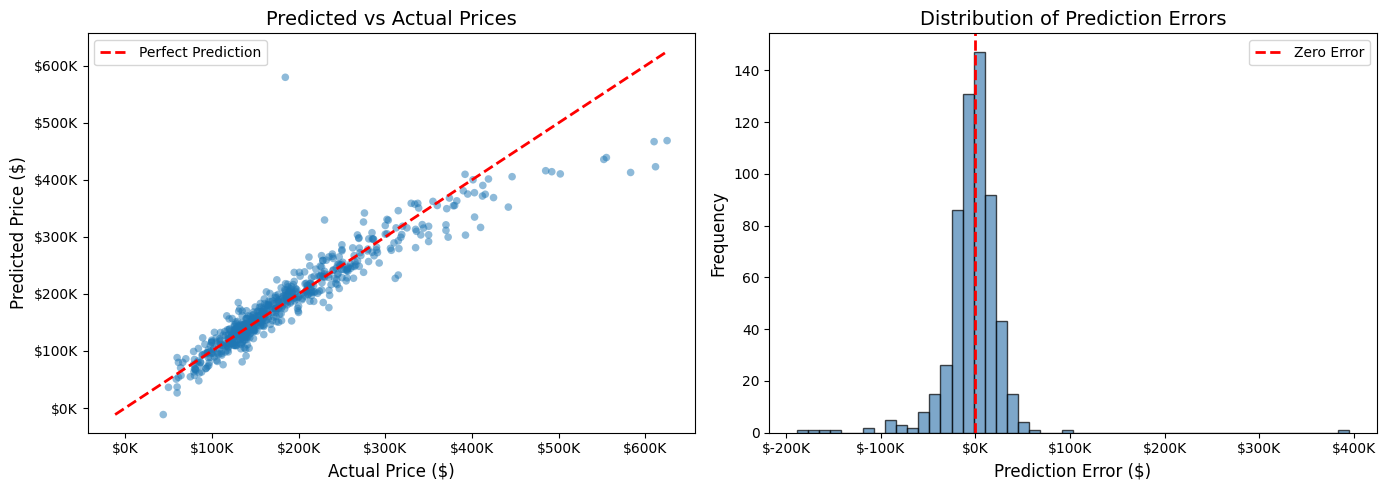

Left plot: Points close to the red line indicate accurate predictions.
Right plot: Errors centered around zero indicate unbiased predictions.

Largest overestimate: $395,015
Largest underestimate: $-188,689


In [17]:
# Visualize Predicted vs Actual Values
# This helps you understand how well the model performs across different price ranges

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Predicted vs Actual scatter plot
ax1 = axes[0]
ax1.scatter(y_true, y_pred, alpha=0.5, edgecolors='none', s=30)
# Add perfect prediction line (where predicted = actual)
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Price ($)', fontsize=12)
ax1.set_ylabel('Predicted Price ($)', fontsize=12)
ax1.set_title('Predicted vs Actual Prices', fontsize=14)
ax1.legend()

# Format axis labels with dollar signs
import matplotlib.ticker as ticker
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Plot 2: Residuals (errors) distribution
ax2 = axes[1]
residuals = y_pred - y_true
ax2.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax2.set_xlabel('Prediction Error ($)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Prediction Errors', fontsize=14)
ax2.legend()
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.show()

print("Left plot: Points close to the red line indicate accurate predictions.")
print("Right plot: Errors centered around zero indicate unbiased predictions.")
print()
print(f"Largest overestimate: ${residuals.max():,.0f}")
print(f"Largest underestimate: ${residuals.min():,.0f}")

In [19]:
# ============================================================
# SINGLE POINT PREDICTION
# ============================================================
# Paste your feature values as a comma-separated string below.
# This should include ALL features (excluding the target variable).

input_values = """
20.0,68.0,11382.0,0.15119454,6.0,5.0,1964.0,1964.0,0.14334472,0.09351536,212.0,54.0,543.0,533.0,1130.0,1374.0,0.0,0.0,1374.0,0.0,1.0,1.0,0.0,3.0,1.0,7.0,1.0,1964.0,1.0,286.0,0.0,28.0,84.0,0.0,0.0,0.0,0.0,8.0,2007.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
"""

# Parse the input
values = [float(x.strip()) for x in input_values.strip().split(',')]
sample = np.array(values).reshape(1, -1)

# Verify feature count matches training data
expected_features = X_train.shape[1]
if len(values) != expected_features:
    print(f"ERROR: You provided {len(values)} features, but the model expects {expected_features}.")
else:
    # Make prediction
    response = predictor.predict(sample)
    predicted_price = float(response['predictions'][0]['score'])
    
    # Calculate context from training data
    target_mean = y_train.mean()
    target_std = y_train.std()
    target_min = y_train.min()
    target_max = y_train.max()
    
    # How many standard deviations from mean?
    z_score = (predicted_price - target_mean) / target_std
    
    print("=" * 60)
    print("SINGLE POINT PREDICTION - REGRESSION")
    print("=" * 60)
    print()
    print(f"  PREDICTED VALUE: ${predicted_price:,.2f}")
    print()
    print("-" * 60)
    print("Context (based on training data):")
    print(f"  Training range:  ${target_min:,.2f} to ${target_max:,.2f}")
    print(f"  Training mean:   ${target_mean:,.2f}")
    print(f"  Training std:    ${target_std:,.2f}")
    print()
    if abs(z_score) < 1:
        print(f"  This prediction is TYPICAL (within 1 std of mean)")
    elif abs(z_score) < 2:
        print(f"  This prediction is SOMEWHAT UNUSUAL ({z_score:.1f} std from mean)")
    else:
        print(f"  This prediction is UNUSUAL ({z_score:.1f} std from mean)")

SINGLE POINT PREDICTION - REGRESSION

  PREDICTED VALUE: $148,045.62

------------------------------------------------------------
Context (based on training data):
  Training range:  $12,789.00 to $755,000.00
  Training mean:   $178,582.21
  Training std:    $77,125.07

  This prediction is TYPICAL (within 1 std of mean)


---
## Step 11: Clean Up Resources

**IMPORTANT: Endpoints cost money as long as they're running!** In AWS Learner Lab, leaving endpoints running will consume your budget.

Run the cell below when you're done to delete your endpoint.

**What gets deleted:**
- The endpoint (the running prediction server)

**What is NOT deleted:**
- Your trained model (saved in S3) - you can re-deploy later if needed
- Your training data (saved in S3)

In [18]:
# ============================================================
# CLEANUP: Delete existing endpoint and configuration
# ============================================================
# Run this cell to check for and remove any existing endpoint
# with the same name. This prevents conflicts when re-running
# the notebook.

import time
import boto3

sm_client = boto3.client('sagemaker')

# Check what exists
endpoint_exists = False
endpoint_config_exists = False
endpoint_status = None

try:
    response = sm_client.describe_endpoint(EndpointName=ENDPOINT_NAME)
    endpoint_exists = True
    endpoint_status = response['EndpointStatus']
except sm_client.exceptions.ClientError:
    pass

try:
    sm_client.describe_endpoint_config(EndpointConfigName=ENDPOINT_NAME)
    endpoint_config_exists = True
except sm_client.exceptions.ClientError:
    pass

# Report what was found
print("=" * 60)
print("ENDPOINT CLEANUP CHECK")
print("=" * 60)
print(f"Endpoint name: {ENDPOINT_NAME}")
print()

if not endpoint_exists and not endpoint_config_exists:
    print("No existing endpoint or configuration found.")
    print("You are ready to deploy!")
else:
    if endpoint_exists:
        print(f"FOUND: Endpoint (status: {endpoint_status})")
    if endpoint_config_exists:
        print(f"FOUND: Endpoint configuration")
    print()
    
    # Prompt for confirmation
    confirm = input("Delete these resources? Type 'yes' to confirm: ")
    
    if confirm.lower() == 'yes':
        print()
        print("Deleting resources...")
        
        # Delete endpoint first (if it exists)
        if endpoint_exists:
            print(f"  Deleting endpoint '{ENDPOINT_NAME}'...")
            sm_client.delete_endpoint(EndpointName=ENDPOINT_NAME)
            
            # Wait for endpoint deletion to complete
            while True:
                try:
                    response = sm_client.describe_endpoint(EndpointName=ENDPOINT_NAME)
                    status = response['EndpointStatus']
                    print(f"    Status: {status}... waiting 15 seconds")
                    time.sleep(15)
                except sm_client.exceptions.ClientError as e:
                    if 'Could not find endpoint' in str(e):
                        print(f"  Endpoint deleted successfully.")
                        break
                    else:
                        raise e
        
        # Delete endpoint configuration (if it exists)
        if endpoint_config_exists:
            print(f"  Deleting endpoint configuration '{ENDPOINT_NAME}'...")
            try:
                sm_client.delete_endpoint_config(EndpointConfigName=ENDPOINT_NAME)
                print(f"  Endpoint configuration deleted successfully.")
            except sm_client.exceptions.ClientError as e:
                if 'Could not find endpoint configuration' in str(e):
                    print(f"  Endpoint configuration already deleted.")
                else:
                    raise e
        
        print()
        print("Cleanup complete! You are ready to deploy.")
    else:
        print()
        print("Deletion cancelled. Existing resources were not changed.")
        print("Note: Deployment may fail if you proceed without cleanup.")

ENDPOINT CLEANUP CHECK
Endpoint name: regression-learner-endpoint

FOUND: Endpoint (status: InService)
FOUND: Endpoint configuration



Delete these resources? Type 'yes' to confirm:  no



Deletion cancelled. Existing resources were not changed.
Note: Deployment may fail if you proceed without cleanup.


---
## Troubleshooting

### Common Errors and Solutions

**"ResourceLimitExceeded" error during training or deployment**
- You may have hit your AWS Learner Lab instance limit
- Solution: Delete any existing endpoints in the SageMaker console, then try again

**"ValidationException: Could not find endpoint" error**
- The endpoint does not exist (may have been deleted or never created)
- Solution: Re-run the deployment cell (Step 8)

**"Endpoint is being created" message takes a long time**
- This is normal! If you previously started creating an endpoint and then re-ran the notebook, 
  the code must wait for the previous creation to complete before it can delete it
- The code will automatically wait up to 15 minutes - just be patient
- If it times out, check the SageMaker console and manually delete the endpoint

**"Cannot create endpoint - endpoint already exists" error**
- This means the cleanup did not complete successfully
- Solution: Go to SageMaker console -> Endpoints -> Delete the endpoint manually, then retry

**Training job fails immediately**
- Check that your CSV file format is correct (target first, no headers)
- Ensure all values are numeric
- Verify the file was uploaded to S3 correctly

**"ModelError" when making predictions**
- The input data format may not match what the model expects
- Ensure you are sending the same number of features as in training
- Check that all values are numeric

**Predictions seem very off (high RMSE)**
- The target variable may have outliers affecting the model
- Consider removing extreme outliers in the Data Validator
- The relationship between features and target may be non-linear

### Session and Timeout Issues

**AWS Learner Lab sessions expire after 4 hours!**
- This is a hard limit - your session will end and resources may be terminated
- Plan your work accordingly: start the notebook, complete training, make predictions, and clean up within the 4-hour window
- If your session expires mid-training, you will need to restart from the beginning in a new session
- Always delete your endpoint before the session expires to avoid unexpected charges

**Session timeout or connection errors**
- AWS Learner Lab sessions expire after 4 hours (see above)
- Solution: Start a new lab session, but note you will need to re-run the notebook from the beginning
- Tip: Save your work frequently and keep track of which cells you have completed

### Running the Notebook Multiple Times

If you run this notebook multiple times (which is totally normal when learning!), the code 
will automatically handle cleaning up old endpoints. Here is what happens:

1. **If no endpoint exists**: Deployment starts immediately
2. **If endpoint is "InService"**: It gets deleted, then the new one is deployed
3. **If endpoint is "Creating"**: The code waits for creation to finish, then deletes it
4. **If endpoint is "Deleting"**: The code waits for deletion to complete

**Tip**: If things get stuck, you can always manually delete endpoints from the 
SageMaker console: Services -> SageMaker -> Inference -> Endpoints

### AWS Learner Lab Specific Issues

**"AccessDeniedException" errors**
- Some AWS features are restricted in Learner Lab
- Stick to the supported instance types: ml.t3.medium, ml.t3.large, ml.t3.xlarge, ml.m5.large, ml.m5.xlarge, ml.c5.large, ml.c5.xlarge

**Running out of budget**
- Always delete endpoints when done
- Avoid leaving training jobs running unnecessarily
- Monitor your budget in the Learner Lab interface

**Notebook instance stopped unexpectedly**
- SageMaker notebook instances auto-stop when the lab session ends
- Your work is saved; just restart the instance in your next session

---
## Summary

Congratulations! You have successfully:

1. Loaded and verified a cleaned dataset
2. Split data into training and validation sets
3. Uploaded data to Amazon S3 (cloud storage)
4. Configured and trained a Linear Learner model for regression
5. Deployed the model to a prediction endpoint
6. Made predictions and evaluated model performance
7. Cleaned up resources to protect your budget

### Key Takeaways for Regression

- Regression predicts **continuous numeric values** (like exact prices, temperatures, or sales figures)
- RMSE and MAE tell you the typical prediction error in the same units as your target
- R-squared tells you how much of the variation your model explains (0 to 1)
- Always clean up endpoints to avoid unnecessary costs

### How Regression Differs from Classification

| Aspect | Regression (This Notebook) | Binary Classification | Multi-class Classification |
|--------|---------------------------|----------------------|---------------------------|
| **Business Question** | "How much?" or "How many?" | "Yes or no?" | "Which category?" |
| **Prediction Output** | A single number | 0 or 1 (with probability) | One of 3+ classes (with probabilities) |
| **Example** | Predict exact price: $185,000 | Above/below median? (yes/no) | Budget/Mid-Range/Premium? |
| **predictor_type** | `'regressor'` | `'binary_classifier'` | `'multiclass_classifier'` |
| **num_classes** | Not needed | Not needed | Required (e.g., 3) |
| **Target values** | Any numeric value | 0 or 1 | 0, 1, 2, ... (starting at 0) |
| **Key metrics** | RMSE, MAE, R-squared | Accuracy, Precision, Recall, F1 | Accuracy, Per-class metrics |
| **Visualization** | Predicted vs Actual scatter | Confusion Matrix (2x2) | Confusion Matrix (NxN) |

### When to Use Regression

Use regression when:
- You need a specific numeric prediction (not just a category)
- The business value comes from knowing the exact amount
- You want to quantify uncertainty in terms of prediction error

Examples: price prediction, demand forecasting, sales projections, time estimates

### Next Steps

- **Binary Classification notebook**: When your question is yes/no (e.g., "Will this customer churn?")
- **Multi-class Classification notebook**: When you need to categorize into 3+ groups (e.g., "Which risk tier?")
- **Your own project**: Use the Data Validator notebook to prepare your own dataset